Using the following dataset
https://www.kaggle.com/mostafafaramin/road-safety-data-accidents-2019
https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales
https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data

In [2]:
# standard data exploration and manipulation package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import 
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# possible targets, time and day of week (create feature)
# can't really predict how many accients will happen on a day, because all the variables change per day and if they don't
# if they don't change everyday then there is nothing to train on

# road surface, carriageway_hazards, did_police officer attend scene, accident severity


def wrangle(fm_path):
    data = pd.read_csv(fm_path, parse_dates=['Date'], index_col='Date')
    
    # drop constant columns
    cols_to_drop = [col for col in data.select_dtypes('object') if data[col].nunique() == 1]
    data.drop(columns=cols_to_drop, inplace=True)

    # drop high cardinality categorical columns
    cols_to_drop = [col for col in data.select_dtypes('object') if data[col].nunique() > 100]
    data.drop(columns=cols_to_drop, inplace=True)    
    
    # drop duplicate info columns
    cols_to_drop = ['Location_Easting_OSGR', 'Location_Northing_OSGR']
    data.drop(columns=cols_to_drop, inplace=True) 
    
    # drop data leakage
    cols_to_drop = ['Number_of_Casualties']
    data.drop(columns=cols_to_drop, inplace=True) 
    
    # combine accident_severity 1 and 2, both as 2
    data['Accident_Severity'].replace(1,2, inplace=True)
    
    return data

In [4]:
DATA_PATH = './data/'
df = wrangle(DATA_PATH + 'Road Safety Data - Accidents 2019.csv')

In [5]:
df.head()

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Road_Type,...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-18,-0.153842,51.508057,1,3,2,2,1,3,4202,1,...,4202,0,5,1,1,1,0,0,1,3
2019-01-15,-0.127949,51.436208,1,3,2,3,9,3,23,2,...,0,-1,-1,4,1,1,0,0,1,3
2019-01-01,-0.124193,51.526795,1,3,2,3,2,4,504,6,...,0,0,0,4,1,1,0,0,1,1
2019-01-01,-0.191044,51.546387,1,2,1,3,2,4,510,6,...,510,0,0,4,1,1,0,0,1,1
2019-01-01,-0.200064,51.541121,1,3,2,3,28,3,4003,6,...,0,0,0,4,1,1,0,0,1,1


In [6]:
target = 'Accident_Severity'
X = df.drop(columns=[target])
y = df[target]

In [7]:
# create X and y train and val splits
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.05, random_state = 42)


In [8]:
# baseline
# target classes are imbalanced
baseline_acc = y_train.value_counts(normalize=True).max()
baseline_acc

0.7859733653355305

In [9]:
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state = 42, n_estimators = 120, learning_rate=0.09, max_depth=4)
)
#model_boost.fit(X_train, y_train)

In [10]:
param_dist = {'gradientboostingclassifier__n_estimators': range(114,124, 2),
              'gradientboostingclassifier__learning_rate': np.arange(0.07, 0.095, .005),
              'gradientboostingclassifier__max_depth': range(3, 5, 1),
             }

clf = RandomizedSearchCV(model_boost, param_distributions = param_dist, n_iter = 10, cv=2, n_jobs = -1, random_state=42)
clf.fit(X_train, y_train)


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.t

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('gradientboostingclassifier',
                                              GradientBoostingClassifier(learning_rate=0.09,
                                                                         max_depth=4,
                                                                         n_estimators=120,
                                                                         random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'gradientboostingclassifier__learning_rate': array([0.07 , 0.075, 0.08 , 0.085, 0.09 ]),
                                        'gradientboostingclassifier__max_depth': range(3, 5),
                                        'gradientboostingclassifier__n_e

In [11]:
clf.best_params_

{'gradientboostingclassifier__n_estimators': 120,
 'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__learning_rate': 0.09000000000000002}

In [12]:
clf.score(X_train, y_train)

0.7888392337384358

In [104]:
#print(f'boosting acc: {model_boost.score(X_train, y_train)}')

boosting acc: 0.7888392337384358


In [13]:
perm_imp = permutation_importance(clf, X_val, y_val, n_jobs = -1, random_state=42)

In [14]:
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']
        }

permutation_importances = pd.DataFrame(data, index = X_val.columns)
permutation_importances

,imp_mean,imp_std
Longitude,0.001293,0.000633
Latitude,0.002688,0.000934
Police_Force,0.001089,0.000204
Number_of_Vehicles,0.003199,0.000953
Day_of_Week,0.000953,0.000350
Local_Authority_(District),0.001225,0.001171
1st_Road_Class,0.000204,0.000394
1st_Road_Number,0.000374,0.000293
Road_Type,0.000272,0.000451
Speed_limit,0.001327,0.000449


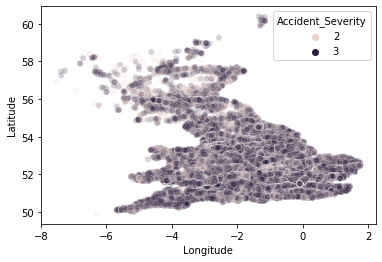

In [15]:
import seaborn as sns
sns.scatterplot('Longitude', 'Latitude', hue='Accident_Severity', data=df, alpha=.2)

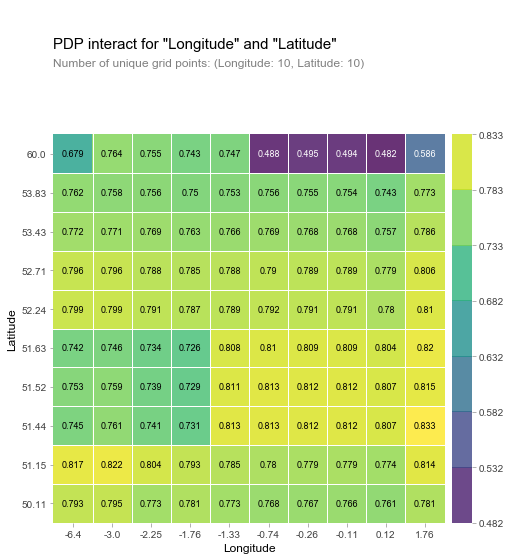

In [17]:
features = ['Longitude', 'Latitude']
# YOUR CODE HERE
plt.rcParams['figure.dpi'] = 72

interaction = pdp_interact(
    model=clf, 
    dataset=X_val.dropna(), 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names = features);